# Generating Dataset

In [2]:
import cv2

cap = cv2.VideoCapture(0)

count1 = 0
count2 = 0
count3 = 0
count4 = 0
while(True):
    ret, frame = cap.read()
    cv2.imshow("Live Video", frame)


    if(cv2.waitKey(1) & 0xFF == ord('a')):
        count1 += 1
        cv2.imwrite(f"dataset/gesture_1/gesture_1_{count1}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('b')):
        count2 += 1
        cv2.imwrite(f"dataset/gesture_2/gesture_2_{count2}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('c')):
        count3 += 1
        cv2.imwrite(f"dataset/gesture_3/gesture_3_{count3}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('d')):
        count4 += 1
        cv2.imwrite(f"dataset/gesture_4/gesture_4_{count4}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('q')):
        cap.release()
        cv2.destroyAllWindows()
        break

<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:24: SyntaxWarning: invalid escape sequence '\g'
<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:24: SyntaxWarning: invalid escape sequence '\g'
<>:28: SyntaxWarning: invalid escape sequence '\g'
C:\Users\gabri\AppData\Local\Temp\ipykernel_19024\3286443979.py:16: SyntaxWarning: invalid escape sequence '\g'
  cv2.imwrite(f"dataset\gesture_1\gesture_1_{count1}.jpg", frame)
C:\Users\gabri\AppData\Local\Temp\ipykernel_19024\3286443979.py:20: SyntaxWarning: invalid escape sequence '\g'
  cv2.imwrite(f"dataset\gesture_2\gesture_2_{count2}.jpg", frame)
C:\Users\gabri\AppData\Local\Temp\ipykernel_19024\3286443979.py:24: SyntaxWarning: invalid escape sequence '\g'
  cv2.imwrite(f"dataset\gesture_3\gesture_3_{count3}.jpg", frame)
C:\Users\gabri\AppData\Local\Temp\ipykernel_19024\32864439

# Save Files in CSV

In [36]:
import os
import csv

# Base directory where the dataset is stored
base_dir = "dataset"

# Output CSV file
output_csv = "images.csv"

# Open the CSV file for writing
with open(output_csv, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Write the headers
    writer.writerow(["Path", "Label"])
    
    # Walk through the dataset directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        
        # Ensure it's a folder
        if os.path.isdir(folder_path):
            label = folder_name  # Use folder name as the label
            if folder_name == "gesture_1":
                label = "checazzo"
            if folder_name == "gesture_2":
                label = "peace"
            if folder_name == "gesture_3":
                label = "nice"
            if folder_name == "gesture_4":
                label = "nogesture"

            
            # Loop through each file in the folder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                
                # Ensure it's an image file (check extension)
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Write the relative path and label to the CSV
                    writer.writerow([file_path, label])

print(f"Images and labels have been saved to {output_csv}")

Images and labels have been saved to images.csv


# Initialize functions

In [1]:
import os
import pandas as pd
import torchvision
import torch
from torchvision import transforms

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from PIL import Image



class CustomImageDataset(Dataset):
    def __init__(self, root_dir,csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(
            ['checazzo', 'peace', 'nice', 'nogesture'])}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")


        label = self.annotations.iloc[idx, 1]
        label = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [2]:
import cv2
import numpy as np
import random


class CustomTransform:
    def __init__(self):
        self.counter_rotation = 0
        self.counter_flipping = 0
        self.counter_blurring = 0
        self.counter_sharpening = 0
        self.counter_noise = 0

    def random_rotation(self, image):
        """Rotate the image by a random angle (45, 90, or 135 degrees) without changing colors."""
        # Reshape image to (height, width, channels)
        image = np.transpose(image, (1, 2, 0))  # Convert (3, 64, 64) to (64, 64, 3)
        rows, cols = image.shape[:2]
        
        # Randomly choose an angle: 45, 90, 135 or 180 degrees
        angle = random.choice([90,180,270])

        # Compute the rotation matrix
        M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), angle, 1)
        
        # Perform the rotation
        dst = cv2.warpAffine(image, M, (cols, rows))
        
        # Reshape image back to (channels, height, width)
        dst = np.transpose(dst, (2, 0, 1))  # Convert (64, 64, 3) back to (3, 64, 64)
        
        self.counter_rotation += 1
        return dst



    def random_flipping(self, image):
        """Flip the image randomly."""
        flip_code = random.choice([-1, 0, 1])  # -1: both axes, 0: vertical, 1: horizontal
        flipped = cv2.flip(image, flip_code)
        self.counter_flipping += 1
        return flipped

    def random_blurring(self, image):
        """Apply random Gaussian blur."""
        kernel_size = random.choice([3, 5, 7])  # Use smaller kernel sizes (3,5 or 7)
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        self.counter_blurring += 1
        return blurred

    def random_sharpening(self, image):
        """Apply a sharpening kernel to the image."""
        kernel = np.array([[-1,-1,-1], 
                           [-1, 9,-1],
                           [-1,-1,-1]])  # Standard sharpening kernel
        sharpened = cv2.filter2D(image, -1, kernel) # Apply the sharpening kernel
        self.counter_sharpening += 1
        return sharpened

    def add_random_noise(self, image):
        """Add random Gaussian noise to an image with controlled intensity."""
        # Transpose image to (height, width, channels) if it's in (channels, height, width)
        image = np.transpose(image, (1, 2, 0))  # (3, 64, 64) to (64, 64, 3)
        
        row, col, ch = image.shape[:3]
        mean = 0
        var = random.uniform(0.001, 0.005)  # Randomly vary the variance (increase from before)
        sigma = var ** 0.5  # Standard deviation is the square root of variance
        
        # Generate Gaussian noise with the updated variance and sigma
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        
        # Add the Gaussian noise to the image
        noisy = image + gauss

        # Clip the image to ensure pixel values are between 0 and 255
        #noisy = np.clip(noisy, 0, 255).astype(np.uint8)

        # Transpose back to (3, 64, 64)
        noisy_image = np.transpose(noisy, (2, 0, 1))  # (64, 64, 3) to (3, 64, 64)

        self.counter_noise += 1
        return noisy_image

    
    # Apply random augmentations
    def __call__(self, image):
        """Apply a random combination of augmentations."""
        augmentations = [
            self.random_rotation,
            self.random_flipping,
            self.random_blurring,
            self.random_sharpening,
            self.add_random_noise
        ]
        random.shuffle(augmentations)  # Shuffle the order of augmentations
    
        # Apply only the first transformation from the shuffled list
        image = augmentations[0](image)
    
        return image, self.counter_rotation, self.counter_flipping, self.counter_blurring, self.counter_sharpening, self.counter_noise  # Return the image and the augmentation counters


In [3]:
import os
import numpy as np
import torch
from PIL import Image
import random
import shutil

# Augment Dataset with Labels and Save Images
def augment_and_add_to_dataset(dataset, transform, num_augmentations=1, save_dir='augmented_dataset'):
    """
    Augment the dataset by applying transformations to each image
    and appending the augmented images with the same labels to the dataset.
    Saves the augmented images in class-specific directories.

    Args:
        dataset: The original dataset (CustomImageDataset or similar).
        transform: The transformation class with custom augmentation functions.
        num_augmentations: Number of augmented versions to create per image.
        save_dir: Root directory where augmented images will be saved.

    Returns:
        Augmented dataset (list of tuples with image tensor and label).
    """
    counter_rotation = 0
    counter_flipping = 0
    counter_blurring = 0
    counter_sharpening = 0
    counter_noise = 0



       # Clear the directory if it exists
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)  # Delete everything inside the folder
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the base directory for augmented dataset

    augmented_data = []

    for idx in range(len(dataset)):
        image, label = dataset[idx]
        
        # Convert tensor back to numpy for transformation
        original_image = image.squeeze(0).numpy()
        #print(original_image.shape)
        # Add the original image and label
        augmented_data.append((image, label))

        # Create class-specific directory if it doesn't exist
        class_dir = os.path.join(save_dir, f'class_{label}')
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Save the original image
        save_image(original_image, class_dir, num_augmentations, 'original')

        # Create augmented versions and save them
        for i in range(num_augmentations):
            augmented_image, counter_rotation,counter_flipping, counter_blurring, counter_sharpening, counter_noise = transform(original_image)
            augmented_image_tensor = torch.tensor(augmented_image)
            
            # Save augmented image
            save_image(augmented_image, class_dir,num_augmentations, f'aug_{i + 1}')
            #print(augmented_image.shape)
            augmented_data.append((augmented_image_tensor, label))
            

     # Apply only the first transformation from the shuffled list
    print("Counter rotation: ", counter_rotation)
    print("Counter flipping: ", counter_flipping)
    print("Counter blurring: ", counter_blurring)
    print("Counter sharpening: ", counter_sharpening)
    print("Counter noise: ", counter_noise)
    return augmented_data


def save_image(image, class_dir, num_augmentations, suffix):
    """
    Save the image to the specified directory with the given suffix.
    """
    
    # If the image has shape (channels, height, width), transpose to (height, width, channels)
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    
    # Convert to uint8 if necessary
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

    #print(f"Processed image shape: {image.shape}, dtype: {image.dtype}")

    # Convert the numpy array to a PIL image
    pil_image = Image.fromarray(image)

    # Create a unique filename for each image
    filename = f"{suffix}_{random.randint(0, 1000)}.jpg"  # Adding randomness to avoid overwriting

    # Save the image in the class directory
    pil_image.save(os.path.join(class_dir, filename))





In [4]:
seed = 42
generator = torch.Generator().manual_seed(seed)

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")


classes = ('checazzo', 'peace', 'nice', 'nogesture')

# Set up transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize the image to 32x32
    transforms.ToTensor(),  # Converts to tensor of shape [1, H, W]
    ])

# Instantiate custom transformation
custom_transform = CustomTransform()
# Create dataset
original_dataset = CustomImageDataset(csv_file='images.csv', root_dir=os.getcwd(), transform=transform)
print(f"Original dataset size: {len(original_dataset)}")

print("original image shape: ", original_dataset[0][0].shape)
# Augment the dataset by 100 images per class
num_augmentations_100 = 1  # Number of augmented versions per original image
dataset_1 = augment_and_add_to_dataset(original_dataset, custom_transform, num_augmentations_100, save_dir='augmented_dataset1')
print(f"Augmented dataset size: {len(dataset_1)}")

# Augment the dataset by 200 images per class
#num_augmentations_200 = 2  # Number of augmented versions per original image
#dataset_2 = augment_and_add_to_dataset(original_dataset, custom_transform, num_augmentations_200, save_dir='augmented_dataset2')
#print(f"Augmented dataset size: {len(dataset_2)}")

# Augment the dataset by 300 images per class
#num_augmentations_300 = 3  # Number of augmented versions per original image
#dataset_3 = augment_and_add_to_dataset(original_dataset, custom_transform, num_augmentations_300, save_dir='augmented_dataset2')
#print(f"Augmented dataset size: {len(dataset_3)}")

# Split dataset into 80% train and 20% test
train_size = int(0.8 * len(dataset_1))
test_size = len(dataset_1) - train_size
train_set, test_set = random_split(dataset_1, [train_size, test_size],generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


Current directory: c:\Visual Computing\Project
Original dataset size: 462
original image shape:  torch.Size([3, 128, 128])
Counter rotation:  86
Counter flipping:  92
Counter blurring:  95
Counter sharpening:  93
Counter noise:  96
Augmented dataset size: 924


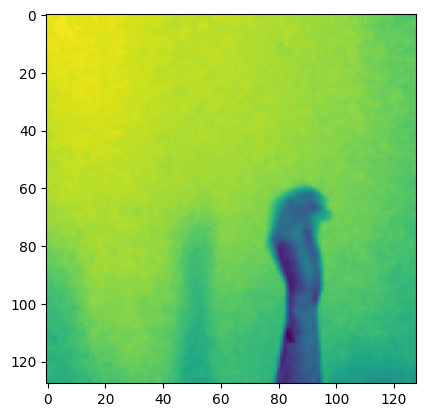

In [5]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()

    # Remove extra singleton dimensions (1, 1, 3, 32, 32) => (3, 32, 32)
    npimg = np.squeeze(npimg)  # Remove the extra singleton dimensions

    # If the image has 3 channels (RGB), we can directly display it
    if npimg.shape[0] == 3:
        npimg = np.transpose(npimg, (1, 2, 0))  # Transpose to (32, 32, 3) for RGB format

    plt.imshow(npimg)  # Show the image with RGB channels
    plt.show()

# Get some random training images
dataset_iter = iter(train_loader)
images, labels = next(dataset_iter)

# Loop through each image in the batch
imshow(images[0][2])  # Display each image in the batch individually


## CNN

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##CNN Architecture

#Generally the CNN output size can be calculated as follows (for an image with same height and width dimensions):
#output_size = ((input_size - kernel_size + 2*padding) / stride) + 1

#Since we transform each image to grayscale we have 1 input channel.
# Also we use padding, because the most relevant informations lie in the center of the images.csv

#input size of each image: 128x128

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=1) #output size = 124x124
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=1) #output size = 60*60
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) #output size = 30*30
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=1) #output size = 14*14
        #self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        #self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # Pooling layer for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layers for regularization
        self.dropout = nn.Dropout(0.5)


        # Fully connected layers
        self.fc1 = nn.Linear(64*7*7, 1000)
        self.fc2 = nn.Linear(1000, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 4) #4 output classes 3 gestures and 1 for no gesture

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # output size = 62*62
        x = self.pool(F.relu(self.conv2(x))) # output size = 30*30
        x = self.pool(F.relu(self.conv3(x))) #output size = 15*15
        x = self.pool(F.relu(self.conv4(x))) # output size = 7*7

       # x = F.relu(self.conv5(x)) #output size = 8x8
       # x = self.pool(F.relu(self.conv6(x))) # output size = 4x4

        x = x.view(-1, 64*7*7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x) #no activation function because we use CrossEntropyLoss

        return x

In [7]:
#Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 100

# Check if the GPU is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)


model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(model)


cpu
Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=4, bias=True)
)


In [8]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [9]:
from torchsummary import summary

summary(model, (3, 128, 128)) # (channels, height, width of input image)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 126, 126]             608
         MaxPool2d-2            [-1, 8, 63, 63]               0
            Conv2d-3           [-1, 16, 61, 61]           3,216
         MaxPool2d-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 30, 30]           4,640
         MaxPool2d-6           [-1, 32, 15, 15]               0
            Conv2d-7           [-1, 64, 14, 14]          32,832
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Linear-9                 [-1, 1000]       3,137,000
          Dropout-10                 [-1, 1000]               0
           Linear-11                  [-1, 512]         512,512
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
          Dropout-14                  [

In [10]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [11]:

def train(model, train_loader, optimizer, criterion, n_epochs=None):
    model.train()
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader,0):
        
        #get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            loss_value = loss.item()
            losses.append(loss_value)
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")

    print('Finished Training')
    return losses


Epoch 1, loss: 1.387321377793948
Epoch 2, loss: 1.3848038266102474
Epoch 3, loss: 1.3798279960950215
Epoch 4, loss: 1.3826387077569962
Epoch 5, loss: 1.357964351773262
Epoch 6, loss: 1.2818364997704823
Epoch 7, loss: 1.1916591723759968
Epoch 8, loss: 1.1882277230421703
Epoch 9, loss: 1.160973459482193
Epoch 10, loss: 1.0756307020783424
Epoch 11, loss: 1.054497706393401
Epoch 12, loss: 0.9731877694527308
Epoch 13, loss: 0.9093151142199835
Epoch 14, loss: 0.8778309859335423
Epoch 15, loss: 0.762818455696106
Epoch 16, loss: 0.6631128787994385
Epoch 17, loss: 0.5033889152109623
Epoch 18, loss: 0.4325815948347251
Epoch 19, loss: 0.35309944736460847
Epoch 20, loss: 0.37042950245086104
Epoch 21, loss: 0.324220306550463
Epoch 22, loss: 0.2670071454097827
Epoch 23, loss: 0.39956169451276463
Epoch 24, loss: 0.5338849316661557
Epoch 25, loss: 0.33635322997967404
Epoch 26, loss: 0.26445387738446396
Epoch 27, loss: 0.20045050885528326
Epoch 28, loss: 0.13174510076620058
Epoch 29, loss: 0.1040862662

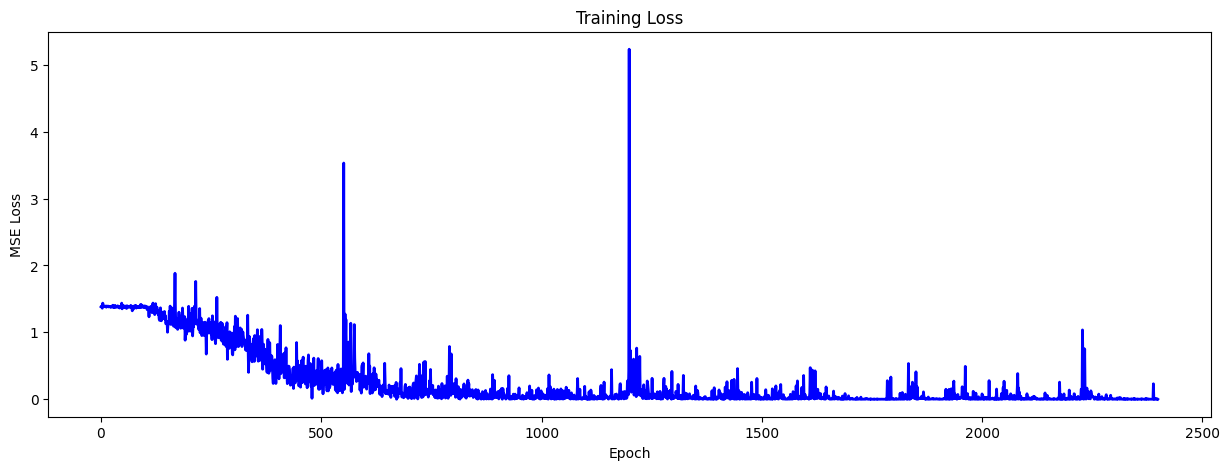

In [12]:
losses = train(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model.pth'
torch.save(model.state_dict(), PATH)

C:\Users\gabri\AppData\Local\Temp\ipykernel_36172\210957378.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))
Clipping input

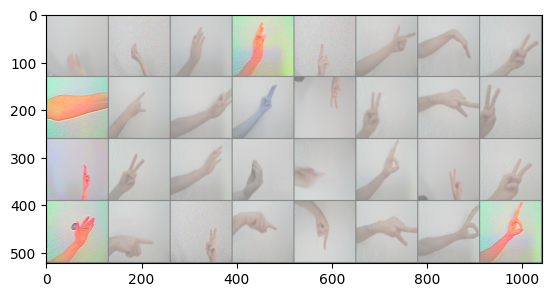

In [13]:
model.load_state_dict(torch.load('model.pth'))

# Check the testset
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))


# Evaluation

In [16]:
def test_accuracy(model, test_loader, device='cpu'):
    """
    Calculate and return the accuracy of the model on the test set.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    """
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute overall accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f} %')
    return accuracy


In [17]:
# Calculate the overall accuracy
overall_accuracy = test_accuracy(model, test_loader, device=device)


Accuracy of the network on the test images: 93.51 %


In [19]:
def accuracy(model, test_loader, classes, device='cpu'):
    """
    Calculate and print the accuracy for each class.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - classes: List of class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - class_accuracies: A dictionary with class names as keys and accuracy percentages as values
    """
    # Switch the model to evaluation mode
    model.eval()

    # Initialize variables for correct and total counts per class
    class_correct = list(0. for _ in range(len(classes)))
    class_total = list(0. for _ in range(len(classes)))

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Compute and print accuracy for each class
    class_accuracies = {}
    for i in range(len(classes)):
        if class_total[i] > 0:  # Check to avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of {classes[i]} : {accuracy:.2f} %')
            class_accuracies[classes[i]] = accuracy
        else:
            print(f'Accuracy of {classes[i]} : No samples available')
            class_accuracies[classes[i]] = None

    return class_accuracies


In [20]:
# Call the accuracy function
class_accuracies = accuracy(model, test_loader, classes, device=device)


Accuracy of checazzo : 91.49 %
Accuracy of peace : 97.73 %
Accuracy of nice : 98.04 %
Accuracy of nogesture : 86.05 %


In [21]:
from sklearn.metrics import f1_score

def calculate_f1_score(y_true, y_pred, average='weighted'):
    """
    Calculate the F1 score for a classification problem.

    Parameters:
    - y_true: List or array of true class labels
    - y_pred: List or array of predicted class labels
    - average: The averaging method ('micro', 'macro', or 'weighted')

    Returns:
    - f1: F1 score (float)
    """
    f1 = f1_score(y_true, y_pred, average=average)
    print(f"F1 Score ({average}): {f1:.2f}")
    return f1


In [22]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and visualize results
def evaluate_model(model, test_loader, label_map, device='cpu',average='weighted'):
    """
    Evaluate the model on a test set and visualize the results.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - label_map: Dictionary mapping class indices to class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    - conf_matrix: Confusion matrix of the test set predictions
    """
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Compute accuracy
    correct = sum(p == l for p, l in zip(all_preds, all_labels))
    total = len(all_labels)
    accuracy = 100 * correct / total

    #Compute F1 score
    f1 = calculate_f1_score(all_labels, all_preds, average=average)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print accuracy
    print(f"Accuracy of the network on the test set: {accuracy:.2f}%")

    # Visualize confusion matrix
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", 
                xticklabels=label_map.values(), 
                yticklabels=label_map.values())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix, f1


F1 Score (weighted): 0.94
Accuracy of the network on the test set: 93.51%


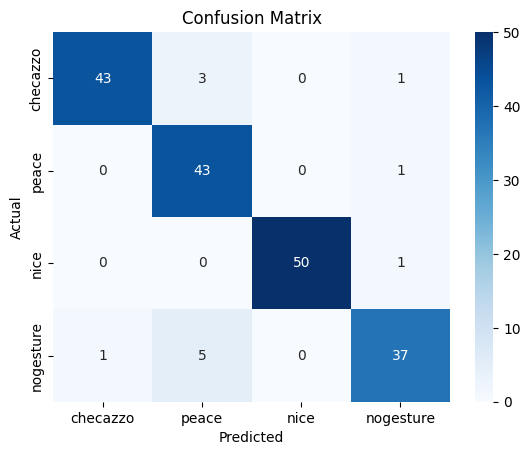

In [23]:
# Define the label map
label_map = {i: class_name for i, class_name in enumerate(classes)}

# Evaluate the model
overall_accuracy, confusion_mat, f1 = evaluate_model(model, test_loader, label_map, device=device,average='weighted')
